In [16]:
TRAINING_WAVEFN_FOURIER_MODES = 3   # 1
TRAINING_TIME = 2.0                 # 0.5
TRAINING_INITIALS = 200             # 200
TRAINING_T_STEPS = 50              # 50
TRAINING_EPOCHS = 1000             # 100
LEARNING_RATE = 0.001              # 0.001
TRAINING_BATCH_SIZE = 1000         # 1000

HIDDEN_DIM = 500    # 500

MSE_HYPERPARAM = 0.1
SCHRODINGER_HYPERPARAM = 1
BOUNDARY_HYPERPARAM = 0.25
INITIAL_CONDS_HYPERPARAM = 0.5
NORM_HYPERPARAM = 0.1

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

if device == "cuda":
    print(f"CUDA available. Using device \"{torch.cuda.get_device_name()}\".")
else:
    print(f"Using CPU device.")

CUDA available. Using device "Tesla P100-PCIE-16GB".


In [18]:
### NUMERICAL SIMULATOR ###
import scipy.integrate
def numerical_schrodinger(initials, ts, grid_size=100, grid_length=1):

    psi0 = initials[0:2, :, :]    
    v = initials[2, :, :]
    shape = psi0.shape
    flattened_shape = np.prod(shape)
    
    # flatten
    psi0 = np.reshape(psi0, flattened_shape)
    
    # construct laplacian operator and then Hamiltonian
    dx = grid_length/grid_size
    D2 = -2*np.eye(grid_size)
    for i in range(grid_size-1):
        D2[i,i+1] = 1 
        D2[i+1,i] = 1
    
    KE = -0.5*D2/(dx**2)
 
    def dpsi_dt(t,y):        
        y = np.reshape(y, shape)
        psi_real = y[0]
        psi_imag = y[1]
        dpsi_real = np.expand_dims(-KE@psi_imag - v*psi_imag, 0)
        dpsi_imag = np.expand_dims(KE@psi_real + v*psi_real, 0)
        return np.reshape(np.concatenate((dpsi_real, dpsi_imag), axis=0), flattened_shape)
    
    #sol = scipy.integrate.odeint(dpsi_dt, psi0, ts)
    sol = scipy.integrate.solve_ivp(dpsi_dt, t_span=[0,np.max(ts)], y0=psi0, t_eval=ts, method="RK23")
    
    return np.reshape(sol.y, shape+(len(ts),))

In [19]:
### TRAINING DATA ###
from tqdm import tqdm
import scipy.interpolate

class SimpleFiniteStepDataset(torch.utils.data.Dataset):
    def __init__(self, grid_size=100, grid_length=1, fourier_modes=TRAINING_WAVEFN_FOURIER_MODES, max_time=TRAINING_TIME, ntimes=TRAINING_T_STEPS, num_initials=TRAINING_INITIALS):
        self.grid_size = grid_size
        self.grid_length = grid_length
        self.fourier_modes = fourier_modes
        self.max_time = max_time
        self.ntimes = ntimes
        self.num_data = num_initials*ntimes*grid_size
        initials = np.empty((3, grid_size, num_initials))
        
        xs = np.linspace(0,grid_length,grid_size)
        
        print('Generating Initials')
        for i in range(num_initials):
            psi0_real, psi0_imag, v = self._generate_initial()
            initials[0, :, i] = psi0_real.T
            initials[1, :, i] = psi0_imag.T
            initials[2, :, i] = v.T
        print('Finished generating initials.')
        
        ts = np.linspace(0, max_time, ntimes)
        integrated = numerical_schrodinger(initials, ts, grid_size, grid_length)
        
        self.data = []
        
        print('the end bit is slow. Starting it now.')
        for i in range(self.num_data):
            a = i%self.ntimes                 # time index
            b = int(i/self.ntimes)%grid_size  # space index
            c = int(i/self.ntimes/grid_size)  # psi0 index
            
            x_real = initials[0,:,c]
            x_imag = initials[1,:,c]
            x_potl = initials[2,:,c]
            
            x = np.concatenate((np.array([xs[b], ts[a]]), x_real, x_imag, x_potl))
            
            y_real = integrated[0,b,c,a]
            y_imag = integrated[1,b,c,a]
            
            y = np.array([y_real, y_imag])
            
            x = torch.tensor(x).float()
            y = torch.tensor(y).float()
            
            self.data.append([x,y])
            
        print('did the end bit')
        
    def __len__(self):
        return self.num_data
    
    def __getitem__(self, index):    
        return self.data[index]
                
    def _generate_initial(self):
        
        # create the initial wave function
        fourier_real_coefficients = 2*np.random.rand(self.fourier_modes)-1
        fourier_imag_coefficients = 2*np.random.rand(self.fourier_modes)-1
        n = np.arange(start=1, stop=self.fourier_modes+1, step=1)

        scale_factor = np.sum(fourier_real_coefficients**2) + np.sum(fourier_imag_coefficients**2)
        scale_factor = (2/(self.grid_length*scale_factor))**0.5
        fourier_real_coefficients *= scale_factor
        fourier_imag_coefficients *= scale_factor
        
        def init_wave_function(x):
            x = np.pi*x/self.grid_length
            psi_real = np.sin(np.outer(x, n))
            psi_real = psi_real*fourier_real_coefficients
            psi_real = np.sum(psi_real, axis=-1)
            
            psi_imag = np.sin(np.outer(x, n))
            psi_imag = psi_imag*fourier_imag_coefficients
            psi_imag = np.sum(psi_imag, axis=-1)
            
            return psi_real, psi_imag
        
        
        # TODO: change when we have a better potential
        potential_function = lambda x: 0*x
        
        x = np.linspace(0, self.grid_length, self.grid_size)
        psi_real, psi_imag = init_wave_function(x)
        v = potential_function(x)
        
        return psi_real, psi_imag, v
        
    

In [20]:
# Generate training data
import time

print('Generating data...')
start = time.perf_counter()
data = SimpleFiniteStepDataset(grid_size=100, fourier_modes=TRAINING_WAVEFN_FOURIER_MODES, max_time=TRAINING_TIME, ntimes=TRAINING_T_STEPS, num_initials=TRAINING_INITIALS)
end = time.perf_counter()
print(f'Training data generated after {end-start} seconds!')

Generating data...
Generating Initials
Finished generating initials.
the end bit is slow. Starting it now.
did the end bit
Training data generated after 93.24225006199777 seconds!


In [21]:
### INTERPOLATE HELPER ###
def batch_interp(funcs, xs):
    batch_size = funcs.shape[0]
    grid_length = funcs.shape[1]
    
    left_pos = torch.zeros((batch_size,1)).type(torch.LongTensor).to(device)
    left_pos[:,0] = torch.floor(xs*grid_length)
    
    right_pos = left_pos.clone()
    right_pos += 1
    
    min_pos = torch.zeros_like(left_pos)
    max_pos = torch.zeros_like(left_pos)
    max_pos += grid_length - 1
    
    right_pos = torch.maximum(torch.minimum(right_pos, max_pos), min_pos)
    left_pos = torch.maximum(torch.minimum(left_pos, max_pos), min_pos)
    
    s = torch.zeros((batch_size,1)).to(device)
    s[:,0] = xs*grid_length - torch.floor(xs*grid_length)
    
    left_sample = torch.gather(funcs, 1, left_pos)
    right_sample = torch.gather(funcs, 1, right_pos)
    
    return (1-s)*left_sample + s*right_sample


# SIMPLIFIED BAD INTERPOLATION FUNCTION
# def batch_interp(funcs, xs):
#     # Have tried adding/removing the two lines below.
#     # funcs = funcs.clone()
#     # xs = xs.clone()
    
#     batch_size = funcs.shape[0]
#     grid_length = funcs.shape[1]
    
#     pos = torch.zeros((batch_size,1)).type(torch.LongTensor).to(device)
#     pos[:,0] = 50
    
#     sample = torch.gather(funcs, 1, pos)
    
#     return sample

# TESTING
# fn = torch.tensor([[1,2,3,1,2,3,1,2,3]]*1000).to(device)
# xs = torch.linspace(-1,2,1000).to(device)
# outs = batch_interp(fn,xs).cpu().detach().numpy()
# import matplotlib.pyplot as plt
# plt.plot(xs.cpu().detach().numpy(),outs)
    

In [22]:
### MODEL DEFN ###
class SimpleFiniteStepSolver(nn.Module):
    def __init__(self, grid_size=100, hidden_dim=300):
        super(SimpleFiniteStepSolver, self).__init__()
        
        self.grid_size = grid_size

        self.mlp = nn.Sequential(
            nn.Linear(3*grid_size+2, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.mlp(x)

In [23]:
# Try to train
from tqdm import tqdm
import matplotlib.pyplot as plt # DEBUG TMP

nepochs = TRAINING_EPOCHS
model = SimpleFiniteStepSolver(grid_size=100, hidden_dim=HIDDEN_DIM).to(device)

train_data_loader = torch.utils.data.DataLoader(data, batch_size=TRAINING_BATCH_SIZE, shuffle=True)

optm = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

mse_hyperparam = MSE_HYPERPARAM
schrod_hyperparam = SCHRODINGER_HYPERPARAM
bc_hyperparam = BOUNDARY_HYPERPARAM
ic_hyperparam = INITIAL_CONDS_HYPERPARAM
norm_hyperparam = NORM_HYPERPARAM

grid_size = model.grid_size

# Schrödinger equation loss
def schrodinger_loss(output, inputs):
    batch_size = output.shape[0]
    
    psi_real = output[:,0]
    psi_imag = output[:,1]
    
    # Calculate Laplacian
    dx = 1e-2 # TODO Make sure the precsion of this is no less than the precision of input
    inputs_x_minus = inputs.clone()
    inputs_x_minus[:,0] -= dx
    inputs_x_plus = inputs.clone()
    inputs_x_plus[:,0] += dx
    
    psi_x_minus = model(inputs_x_minus)
    psi_x_plus = model(inputs_x_plus)
    psi_d2x = (psi_x_plus + psi_x_minus - 2*output)/(dx**2)
    
    psi_d2x_real = psi_d2x[:,0]
    psi_d2x_imag = psi_d2x[:,1]
    
    # Calculate time derivative
    dt = 1e-5
    inputs_t_minus = inputs.clone()
    inputs_t_minus[:,1] -= dt
    inputs_t_plus = inputs.clone()
    inputs_t_plus[:,1] += dt
    
    psi_t_minus = model(inputs_t_minus)
    psi_t_plus = model(inputs_t_plus)
    
    psi_dt = (psi_t_plus - psi_t_minus)/(2*dt)
    
    psi_dt_real = psi_dt[:,0]
    psi_dt_imag = psi_dt[:,1]
    
    # Calculate potential energy
    # V_grid = inputs[:,2*grid_size+2:]
    # V = batch_interp(V_grid,inputs[:,0])
    V = 0
    
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # Calculate loss
    diff_1 = psi_dt_real - 0.5*psi_d2x_imag + V_imag
    diff_2 = psi_dt_imag + 0.5*psi_d2x_real - V_real

    return torch.mean(diff_1**2 + diff_2**2)

# Boundary condition loss
def bc_loss(inputs):    
    inputs_left = inputs.clone()
    inputs_left[:,0] = 0
    outputs_left = model(inputs_left)
    
    inputs_right = inputs.clone()
    inputs_right[:,0] = 1
    outputs_right = model(inputs_right)
    
    return torch.mean(outputs_left**2 + outputs_right**2)

# Initial condition loss
def ic_loss(inputs):    
    inputs_initial = inputs.clone()
    inputs_initial[:,1] = 0
    outputs_initial = model(inputs_initial)
    
    psi0_real = inputs[:,2:grid_size+2]
    psi0_imag = inputs[:,grid_size+2:2*grid_size+2]
    xs = inputs[:,0]
    
    targets_real = batch_interp(psi0_real, xs)
    targets_imag = batch_interp(psi0_imag, xs)
    
    return torch.mean((outputs_initial[:,0] - targets_real[:,0])**2 + (outputs_initial[:,1] - targets_imag[:,0])**2)

# Normalisation Loss
legendre_n = 10
legendre_xs, legendre_ws = scipy.special.roots_legendre(legendre_n)
legendre_xs = (legendre_xs + 1.0)/2.0
legendre_xs = torch.tensor(legendre_xs).to(device).float()
legendre_ws = torch.tensor(legendre_ws).to(device).float()

def norm_loss(inputs):
    batch_size = inputs.shape[0]
    inputs_clone = inputs.clone()
    inputs_clone = inputs_clone.expand(legendre_n,-1,-1).clone()
    xs_expanded = legendre_xs.expand(batch_size, -1).T
    inputs_clone[:,:,0] = xs_expanded
    inputs_clone = torch.reshape(inputs_clone, (batch_size*legendre_n, -1))
    outputs = model(inputs_clone)
    outputs = torch.reshape(outputs, (legendre_n, batch_size, -1))
    outputs = outputs[:,:,0]**2 + outputs[:,:,1]**2
    norms = torch.inner(outputs.T, legendre_ws)/2
    return torch.mean((norms-1)**2)


def custom_loss(output, inputs, target):    
    mse =  F.mse_loss(output,y)
    schrod_loss = schrodinger_loss(output, inputs) if schrod_hyperparam != 0 else 0
    bcds_loss = bc_loss(inputs) if bc_hyperparam != 0 else 0
    ics_loss = ic_loss(inputs) if ic_hyperparam != 0 else 0
    norm_loss_value = norm_loss(inputs) if norm_hyperparam != 0 else 0
    
    return mse_hyperparam*mse + bc_hyperparam*bcds_loss + ic_hyperparam*ics_loss + schrod_hyperparam*schrod_loss + norm_hyperparam*norm_loss_value
    

for epoch in range(nepochs):
    epoch_loss = 0
    mse_loss = 0
    
    for x,y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        
        optm.zero_grad()
        output = model(x)     
        loss = custom_loss(output,x,y)
        
        loss.backward()
        optm.step()

        mse_loss += F.mse_loss(output,y)/len(train_data_loader)
        epoch_loss+=loss/len(train_data_loader)
        
    print('Epoch {} Loss : {:.3e} \t (MSE Loss {:.3e})'.format((epoch+1),epoch_loss, mse_loss))

100%|██████████| 1000/1000 [00:23<00:00, 42.09it/s]


Epoch 1 Loss : 5.527e-01 	 (MSE Loss 5.862e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.42it/s]


Epoch 2 Loss : 4.630e-01 	 (MSE Loss 5.551e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.36it/s]


Epoch 3 Loss : 4.022e-01 	 (MSE Loss 5.276e-01)


100%|██████████| 1000/1000 [00:22<00:00, 43.62it/s]


Epoch 4 Loss : 3.576e-01 	 (MSE Loss 5.238e-01)


100%|██████████| 1000/1000 [00:23<00:00, 42.29it/s]


Epoch 5 Loss : 3.162e-01 	 (MSE Loss 5.226e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.55it/s]


Epoch 6 Loss : 2.738e-01 	 (MSE Loss 5.344e-01)


100%|██████████| 1000/1000 [00:20<00:00, 48.42it/s]


Epoch 7 Loss : 2.350e-01 	 (MSE Loss 5.180e-01)


100%|██████████| 1000/1000 [00:20<00:00, 49.61it/s]


Epoch 8 Loss : 2.137e-01 	 (MSE Loss 5.034e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.06it/s]


Epoch 9 Loss : 2.010e-01 	 (MSE Loss 4.944e-01)


100%|██████████| 1000/1000 [00:20<00:00, 49.73it/s]


Epoch 10 Loss : 1.895e-01 	 (MSE Loss 4.872e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.65it/s]


Epoch 11 Loss : 1.819e-01 	 (MSE Loss 4.795e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.67it/s]


Epoch 12 Loss : 1.730e-01 	 (MSE Loss 4.726e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.33it/s]


Epoch 13 Loss : 1.666e-01 	 (MSE Loss 4.639e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


Epoch 14 Loss : 1.586e-01 	 (MSE Loss 4.564e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.24it/s]


Epoch 15 Loss : 1.509e-01 	 (MSE Loss 4.495e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.32it/s]


Epoch 16 Loss : 1.454e-01 	 (MSE Loss 4.433e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.28it/s]


Epoch 17 Loss : 1.455e-01 	 (MSE Loss 4.382e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.22it/s]


Epoch 18 Loss : 1.349e-01 	 (MSE Loss 4.346e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.24it/s]


Epoch 19 Loss : 1.313e-01 	 (MSE Loss 4.311e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.20it/s]


Epoch 20 Loss : 1.291e-01 	 (MSE Loss 4.276e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]


Epoch 21 Loss : 1.232e-01 	 (MSE Loss 4.257e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.18it/s]


Epoch 22 Loss : 1.212e-01 	 (MSE Loss 4.233e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.19it/s]


Epoch 23 Loss : 1.206e-01 	 (MSE Loss 4.212e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.17it/s]


Epoch 24 Loss : 1.165e-01 	 (MSE Loss 4.196e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.21it/s]


Epoch 25 Loss : 1.167e-01 	 (MSE Loss 4.176e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


Epoch 26 Loss : 1.121e-01 	 (MSE Loss 4.161e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.51it/s]


Epoch 27 Loss : 1.106e-01 	 (MSE Loss 4.148e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


Epoch 28 Loss : 1.098e-01 	 (MSE Loss 4.132e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.23it/s]


Epoch 29 Loss : 1.071e-01 	 (MSE Loss 4.121e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.08it/s]


Epoch 30 Loss : 1.053e-01 	 (MSE Loss 4.108e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.19it/s]


Epoch 31 Loss : 1.092e-01 	 (MSE Loss 4.089e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.52it/s]


Epoch 32 Loss : 1.017e-01 	 (MSE Loss 4.086e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.81it/s]


Epoch 33 Loss : 1.032e-01 	 (MSE Loss 4.071e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 34 Loss : 1.004e-01 	 (MSE Loss 4.061e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 35 Loss : 1.012e-01 	 (MSE Loss 4.048e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.16it/s]


Epoch 36 Loss : 9.847e-02 	 (MSE Loss 4.038e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.17it/s]


Epoch 37 Loss : 9.888e-02 	 (MSE Loss 4.026e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.10it/s]


Epoch 38 Loss : 9.579e-02 	 (MSE Loss 4.019e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.19it/s]


Epoch 39 Loss : 9.524e-02 	 (MSE Loss 4.011e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


Epoch 40 Loss : 9.596e-02 	 (MSE Loss 4.000e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.22it/s]


Epoch 41 Loss : 9.427e-02 	 (MSE Loss 3.994e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.12it/s]


Epoch 42 Loss : 9.335e-02 	 (MSE Loss 3.984e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.21it/s]


Epoch 43 Loss : 9.281e-02 	 (MSE Loss 3.975e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.23it/s]


Epoch 44 Loss : 9.265e-02 	 (MSE Loss 3.970e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


Epoch 45 Loss : 8.840e-02 	 (MSE Loss 3.967e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]


Epoch 46 Loss : 9.101e-02 	 (MSE Loss 3.957e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


Epoch 47 Loss : 8.928e-02 	 (MSE Loss 3.952e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.21it/s]


Epoch 48 Loss : 8.835e-02 	 (MSE Loss 3.945e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.23it/s]


Epoch 49 Loss : 8.725e-02 	 (MSE Loss 3.938e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.12it/s]


Epoch 50 Loss : 8.741e-02 	 (MSE Loss 3.935e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s]


Epoch 51 Loss : 8.627e-02 	 (MSE Loss 3.931e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


Epoch 52 Loss : 8.572e-02 	 (MSE Loss 3.926e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.22it/s]


Epoch 53 Loss : 8.652e-02 	 (MSE Loss 3.917e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 54 Loss : 8.334e-02 	 (MSE Loss 3.919e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 55 Loss : 8.518e-02 	 (MSE Loss 3.914e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.17it/s]


Epoch 56 Loss : 8.402e-02 	 (MSE Loss 3.910e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 57 Loss : 8.170e-02 	 (MSE Loss 3.907e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.20it/s]


Epoch 58 Loss : 8.190e-02 	 (MSE Loss 3.903e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.07it/s]


Epoch 59 Loss : 8.255e-02 	 (MSE Loss 3.897e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.20it/s]


Epoch 60 Loss : 7.974e-02 	 (MSE Loss 3.900e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.18it/s]


Epoch 61 Loss : 8.202e-02 	 (MSE Loss 3.893e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.24it/s]


Epoch 62 Loss : 8.010e-02 	 (MSE Loss 3.892e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.24it/s]


Epoch 63 Loss : 8.131e-02 	 (MSE Loss 3.889e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


Epoch 64 Loss : 7.973e-02 	 (MSE Loss 3.889e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.05it/s]


Epoch 65 Loss : 8.064e-02 	 (MSE Loss 3.884e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


Epoch 66 Loss : 8.026e-02 	 (MSE Loss 3.881e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 67 Loss : 7.825e-02 	 (MSE Loss 3.882e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.12it/s]


Epoch 68 Loss : 7.748e-02 	 (MSE Loss 3.878e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 69 Loss : 7.755e-02 	 (MSE Loss 3.874e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.10it/s]


Epoch 70 Loss : 7.838e-02 	 (MSE Loss 3.872e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.79it/s]


Epoch 71 Loss : 7.678e-02 	 (MSE Loss 3.873e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 72 Loss : 7.756e-02 	 (MSE Loss 3.868e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 73 Loss : 7.701e-02 	 (MSE Loss 3.869e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.20it/s]


Epoch 74 Loss : 7.660e-02 	 (MSE Loss 3.868e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 75 Loss : 7.601e-02 	 (MSE Loss 3.864e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.22it/s]


Epoch 76 Loss : 7.479e-02 	 (MSE Loss 3.864e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 77 Loss : 7.568e-02 	 (MSE Loss 3.859e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.05it/s]


Epoch 78 Loss : 7.427e-02 	 (MSE Loss 3.860e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 79 Loss : 7.457e-02 	 (MSE Loss 3.861e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 80 Loss : 7.450e-02 	 (MSE Loss 3.855e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


Epoch 81 Loss : 7.388e-02 	 (MSE Loss 3.854e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.04it/s]


Epoch 82 Loss : 7.575e-02 	 (MSE Loss 3.852e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.02it/s]


Epoch 83 Loss : 7.211e-02 	 (MSE Loss 3.852e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.72it/s]


Epoch 84 Loss : 7.519e-02 	 (MSE Loss 3.848e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 85 Loss : 7.121e-02 	 (MSE Loss 3.853e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.12it/s]


Epoch 86 Loss : 7.249e-02 	 (MSE Loss 3.847e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 87 Loss : 7.374e-02 	 (MSE Loss 3.846e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


Epoch 88 Loss : 7.305e-02 	 (MSE Loss 3.844e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.07it/s]


Epoch 89 Loss : 7.179e-02 	 (MSE Loss 3.844e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 90 Loss : 7.078e-02 	 (MSE Loss 3.842e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.13it/s]


Epoch 91 Loss : 7.104e-02 	 (MSE Loss 3.842e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.05it/s]


Epoch 92 Loss : 7.257e-02 	 (MSE Loss 3.838e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


Epoch 93 Loss : 6.971e-02 	 (MSE Loss 3.839e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 94 Loss : 7.204e-02 	 (MSE Loss 3.835e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.02it/s]


Epoch 95 Loss : 7.024e-02 	 (MSE Loss 3.835e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


Epoch 96 Loss : 7.112e-02 	 (MSE Loss 3.834e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.74it/s]


Epoch 97 Loss : 6.963e-02 	 (MSE Loss 3.835e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 98 Loss : 7.057e-02 	 (MSE Loss 3.831e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.00it/s]


Epoch 99 Loss : 6.892e-02 	 (MSE Loss 3.832e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 100 Loss : 7.001e-02 	 (MSE Loss 3.829e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.10it/s]


Epoch 101 Loss : 7.027e-02 	 (MSE Loss 3.829e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s]


Epoch 102 Loss : 6.878e-02 	 (MSE Loss 3.828e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s]


Epoch 103 Loss : 6.851e-02 	 (MSE Loss 3.827e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.02it/s]


Epoch 104 Loss : 6.763e-02 	 (MSE Loss 3.826e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 105 Loss : 6.953e-02 	 (MSE Loss 3.823e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.05it/s]


Epoch 106 Loss : 6.945e-02 	 (MSE Loss 3.824e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 107 Loss : 6.801e-02 	 (MSE Loss 3.824e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.21it/s]


Epoch 108 Loss : 6.955e-02 	 (MSE Loss 3.822e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.74it/s]


Epoch 109 Loss : 6.628e-02 	 (MSE Loss 3.822e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.13it/s]


Epoch 110 Loss : 6.841e-02 	 (MSE Loss 3.818e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.05it/s]


Epoch 111 Loss : 6.608e-02 	 (MSE Loss 3.819e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


Epoch 112 Loss : 6.955e-02 	 (MSE Loss 3.816e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 113 Loss : 6.564e-02 	 (MSE Loss 3.819e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Epoch 114 Loss : 6.718e-02 	 (MSE Loss 3.815e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s]


Epoch 115 Loss : 6.616e-02 	 (MSE Loss 3.817e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.12it/s]


Epoch 116 Loss : 6.599e-02 	 (MSE Loss 3.814e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.00it/s]


Epoch 117 Loss : 6.653e-02 	 (MSE Loss 3.811e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 118 Loss : 6.636e-02 	 (MSE Loss 3.812e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


Epoch 119 Loss : 6.583e-02 	 (MSE Loss 3.811e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.00it/s]


Epoch 120 Loss : 6.567e-02 	 (MSE Loss 3.812e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 121 Loss : 6.582e-02 	 (MSE Loss 3.808e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.68it/s]


Epoch 122 Loss : 6.682e-02 	 (MSE Loss 3.807e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.35it/s]


Epoch 123 Loss : 6.458e-02 	 (MSE Loss 3.808e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 124 Loss : 6.603e-02 	 (MSE Loss 3.806e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s]


Epoch 125 Loss : 6.604e-02 	 (MSE Loss 3.806e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.00it/s]


Epoch 126 Loss : 6.426e-02 	 (MSE Loss 3.806e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.96it/s]


Epoch 127 Loss : 6.509e-02 	 (MSE Loss 3.803e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 128 Loss : 6.496e-02 	 (MSE Loss 3.803e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 129 Loss : 6.465e-02 	 (MSE Loss 3.802e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.07it/s]


Epoch 130 Loss : 6.355e-02 	 (MSE Loss 3.803e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 131 Loss : 6.694e-02 	 (MSE Loss 3.800e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.02it/s]


Epoch 132 Loss : 6.313e-02 	 (MSE Loss 3.800e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


Epoch 133 Loss : 6.467e-02 	 (MSE Loss 3.800e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]


Epoch 134 Loss : 6.357e-02 	 (MSE Loss 3.798e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s]


Epoch 135 Loss : 6.494e-02 	 (MSE Loss 3.798e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 136 Loss : 6.303e-02 	 (MSE Loss 3.799e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


Epoch 137 Loss : 6.398e-02 	 (MSE Loss 3.795e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


Epoch 138 Loss : 6.390e-02 	 (MSE Loss 3.795e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 139 Loss : 6.357e-02 	 (MSE Loss 3.794e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


Epoch 140 Loss : 6.271e-02 	 (MSE Loss 3.795e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


Epoch 141 Loss : 6.465e-02 	 (MSE Loss 3.790e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 142 Loss : 6.249e-02 	 (MSE Loss 3.793e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 143 Loss : 6.460e-02 	 (MSE Loss 3.790e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.95it/s]


Epoch 144 Loss : 6.278e-02 	 (MSE Loss 3.791e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 145 Loss : 6.192e-02 	 (MSE Loss 3.792e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 146 Loss : 6.305e-02 	 (MSE Loss 3.788e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]


Epoch 147 Loss : 6.307e-02 	 (MSE Loss 3.789e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.96it/s]


Epoch 148 Loss : 6.237e-02 	 (MSE Loss 3.789e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 149 Loss : 6.149e-02 	 (MSE Loss 3.788e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.02it/s]


Epoch 150 Loss : 6.273e-02 	 (MSE Loss 3.785e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 151 Loss : 6.254e-02 	 (MSE Loss 3.786e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.95it/s]


Epoch 152 Loss : 6.215e-02 	 (MSE Loss 3.785e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.08it/s]


Epoch 153 Loss : 6.269e-02 	 (MSE Loss 3.783e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 154 Loss : 6.119e-02 	 (MSE Loss 3.785e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 155 Loss : 6.112e-02 	 (MSE Loss 3.783e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


Epoch 156 Loss : 6.200e-02 	 (MSE Loss 3.780e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.96it/s]


Epoch 157 Loss : 6.148e-02 	 (MSE Loss 3.782e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.05it/s]


Epoch 158 Loss : 6.137e-02 	 (MSE Loss 3.781e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 159 Loss : 6.185e-02 	 (MSE Loss 3.780e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.51it/s]


Epoch 160 Loss : 6.189e-02 	 (MSE Loss 3.779e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 161 Loss : 6.058e-02 	 (MSE Loss 3.779e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.04it/s]


Epoch 162 Loss : 6.197e-02 	 (MSE Loss 3.778e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 163 Loss : 6.089e-02 	 (MSE Loss 3.779e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.97it/s]


Epoch 164 Loss : 6.142e-02 	 (MSE Loss 3.776e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 165 Loss : 6.032e-02 	 (MSE Loss 3.778e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.95it/s]


Epoch 166 Loss : 6.170e-02 	 (MSE Loss 3.774e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.95it/s]


Epoch 167 Loss : 6.018e-02 	 (MSE Loss 3.775e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.94it/s]


Epoch 168 Loss : 6.085e-02 	 (MSE Loss 3.774e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 169 Loss : 6.015e-02 	 (MSE Loss 3.773e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 170 Loss : 6.014e-02 	 (MSE Loss 3.773e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 171 Loss : 6.084e-02 	 (MSE Loss 3.771e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]


Epoch 172 Loss : 6.011e-02 	 (MSE Loss 3.772e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 173 Loss : 6.074e-02 	 (MSE Loss 3.770e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 174 Loss : 5.946e-02 	 (MSE Loss 3.770e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 175 Loss : 6.104e-02 	 (MSE Loss 3.769e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


Epoch 176 Loss : 6.030e-02 	 (MSE Loss 3.769e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 177 Loss : 6.033e-02 	 (MSE Loss 3.768e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.94it/s]


Epoch 178 Loss : 5.920e-02 	 (MSE Loss 3.768e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Epoch 179 Loss : 6.014e-02 	 (MSE Loss 3.766e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 180 Loss : 5.942e-02 	 (MSE Loss 3.767e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 181 Loss : 5.990e-02 	 (MSE Loss 3.765e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.79it/s]


Epoch 182 Loss : 5.924e-02 	 (MSE Loss 3.764e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.17it/s]


Epoch 183 Loss : 6.006e-02 	 (MSE Loss 3.764e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.95it/s]


Epoch 184 Loss : 5.898e-02 	 (MSE Loss 3.765e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]


Epoch 185 Loss : 5.972e-02 	 (MSE Loss 3.763e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 186 Loss : 6.003e-02 	 (MSE Loss 3.762e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.97it/s]


Epoch 187 Loss : 5.881e-02 	 (MSE Loss 3.763e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 188 Loss : 5.885e-02 	 (MSE Loss 3.761e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Epoch 189 Loss : 5.943e-02 	 (MSE Loss 3.760e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


Epoch 190 Loss : 5.919e-02 	 (MSE Loss 3.761e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


Epoch 191 Loss : 5.832e-02 	 (MSE Loss 3.760e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 192 Loss : 6.003e-02 	 (MSE Loss 3.758e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 193 Loss : 5.770e-02 	 (MSE Loss 3.759e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 194 Loss : 5.961e-02 	 (MSE Loss 3.756e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 195 Loss : 5.959e-02 	 (MSE Loss 3.757e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 196 Loss : 5.856e-02 	 (MSE Loss 3.757e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.43it/s]


Epoch 197 Loss : 5.800e-02 	 (MSE Loss 3.757e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 198 Loss : 5.825e-02 	 (MSE Loss 3.756e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 199 Loss : 5.827e-02 	 (MSE Loss 3.754e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


Epoch 200 Loss : 5.895e-02 	 (MSE Loss 3.752e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 201 Loss : 5.845e-02 	 (MSE Loss 3.754e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 202 Loss : 5.779e-02 	 (MSE Loss 3.753e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.07it/s]


Epoch 203 Loss : 5.789e-02 	 (MSE Loss 3.752e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 204 Loss : 6.048e-02 	 (MSE Loss 3.750e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.84it/s]


Epoch 205 Loss : 5.719e-02 	 (MSE Loss 3.753e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


Epoch 206 Loss : 5.898e-02 	 (MSE Loss 3.751e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 207 Loss : 5.783e-02 	 (MSE Loss 3.750e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.67it/s]


Epoch 208 Loss : 5.850e-02 	 (MSE Loss 3.750e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.79it/s]


Epoch 209 Loss : 5.671e-02 	 (MSE Loss 3.750e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.51it/s]


Epoch 210 Loss : 5.802e-02 	 (MSE Loss 3.748e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 211 Loss : 5.881e-02 	 (MSE Loss 3.746e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 212 Loss : 5.723e-02 	 (MSE Loss 3.748e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 213 Loss : 5.713e-02 	 (MSE Loss 3.746e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.94it/s]


Epoch 214 Loss : 5.774e-02 	 (MSE Loss 3.744e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.84it/s]


Epoch 215 Loss : 5.840e-02 	 (MSE Loss 3.745e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 216 Loss : 5.653e-02 	 (MSE Loss 3.745e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 217 Loss : 5.771e-02 	 (MSE Loss 3.742e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Epoch 218 Loss : 5.721e-02 	 (MSE Loss 3.745e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 219 Loss : 5.712e-02 	 (MSE Loss 3.741e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 220 Loss : 5.784e-02 	 (MSE Loss 3.742e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 221 Loss : 5.706e-02 	 (MSE Loss 3.742e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 222 Loss : 5.759e-02 	 (MSE Loss 3.740e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.49it/s]


Epoch 223 Loss : 5.675e-02 	 (MSE Loss 3.741e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 224 Loss : 5.691e-02 	 (MSE Loss 3.739e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 225 Loss : 5.672e-02 	 (MSE Loss 3.738e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 226 Loss : 5.723e-02 	 (MSE Loss 3.737e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 227 Loss : 5.777e-02 	 (MSE Loss 3.737e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.77it/s]


Epoch 228 Loss : 5.706e-02 	 (MSE Loss 3.737e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


Epoch 229 Loss : 5.664e-02 	 (MSE Loss 3.737e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 230 Loss : 5.736e-02 	 (MSE Loss 3.735e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 231 Loss : 5.691e-02 	 (MSE Loss 3.736e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


Epoch 232 Loss : 5.622e-02 	 (MSE Loss 3.735e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 233 Loss : 5.710e-02 	 (MSE Loss 3.733e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.67it/s]


Epoch 234 Loss : 5.605e-02 	 (MSE Loss 3.734e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]


Epoch 235 Loss : 5.653e-02 	 (MSE Loss 3.732e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


Epoch 236 Loss : 5.706e-02 	 (MSE Loss 3.730e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 237 Loss : 5.645e-02 	 (MSE Loss 3.732e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Epoch 238 Loss : 5.600e-02 	 (MSE Loss 3.731e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


Epoch 239 Loss : 5.674e-02 	 (MSE Loss 3.730e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 240 Loss : 5.590e-02 	 (MSE Loss 3.728e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 241 Loss : 5.670e-02 	 (MSE Loss 3.728e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 242 Loss : 5.625e-02 	 (MSE Loss 3.728e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 243 Loss : 5.542e-02 	 (MSE Loss 3.727e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Epoch 244 Loss : 5.603e-02 	 (MSE Loss 3.726e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 245 Loss : 5.633e-02 	 (MSE Loss 3.726e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


Epoch 246 Loss : 5.647e-02 	 (MSE Loss 3.724e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 247 Loss : 5.559e-02 	 (MSE Loss 3.726e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.50it/s]


Epoch 248 Loss : 5.536e-02 	 (MSE Loss 3.723e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.80it/s]


Epoch 249 Loss : 5.647e-02 	 (MSE Loss 3.722e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


Epoch 250 Loss : 5.562e-02 	 (MSE Loss 3.723e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 251 Loss : 5.556e-02 	 (MSE Loss 3.722e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.80it/s]


Epoch 252 Loss : 5.525e-02 	 (MSE Loss 3.721e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.84it/s]


Epoch 253 Loss : 5.591e-02 	 (MSE Loss 3.720e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


Epoch 254 Loss : 5.613e-02 	 (MSE Loss 3.719e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.79it/s]


Epoch 255 Loss : 5.534e-02 	 (MSE Loss 3.720e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.77it/s]


Epoch 256 Loss : 5.571e-02 	 (MSE Loss 3.718e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 257 Loss : 5.482e-02 	 (MSE Loss 3.718e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 258 Loss : 5.570e-02 	 (MSE Loss 3.717e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Epoch 259 Loss : 5.569e-02 	 (MSE Loss 3.716e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


Epoch 260 Loss : 5.566e-02 	 (MSE Loss 3.715e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.33it/s]


Epoch 261 Loss : 5.550e-02 	 (MSE Loss 3.716e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Epoch 262 Loss : 5.456e-02 	 (MSE Loss 3.715e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


Epoch 263 Loss : 5.506e-02 	 (MSE Loss 3.714e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


Epoch 264 Loss : 5.510e-02 	 (MSE Loss 3.711e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 265 Loss : 5.631e-02 	 (MSE Loss 3.710e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


Epoch 266 Loss : 5.449e-02 	 (MSE Loss 3.713e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 267 Loss : 5.465e-02 	 (MSE Loss 3.711e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 268 Loss : 5.514e-02 	 (MSE Loss 3.710e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Epoch 269 Loss : 5.439e-02 	 (MSE Loss 3.709e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 270 Loss : 5.532e-02 	 (MSE Loss 3.708e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s]


Epoch 271 Loss : 5.494e-02 	 (MSE Loss 3.707e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


Epoch 272 Loss : 5.427e-02 	 (MSE Loss 3.707e-01)


100%|██████████| 1000/1000 [00:18<00:00, 52.66it/s]


Epoch 273 Loss : 5.522e-02 	 (MSE Loss 3.704e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 274 Loss : 5.427e-02 	 (MSE Loss 3.706e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 275 Loss : 5.477e-02 	 (MSE Loss 3.704e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Epoch 276 Loss : 5.485e-02 	 (MSE Loss 3.705e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Epoch 277 Loss : 5.446e-02 	 (MSE Loss 3.702e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.73it/s]


Epoch 278 Loss : 5.461e-02 	 (MSE Loss 3.702e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s]


Epoch 279 Loss : 5.478e-02 	 (MSE Loss 3.701e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.60it/s]


Epoch 280 Loss : 5.424e-02 	 (MSE Loss 3.700e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.77it/s]


Epoch 281 Loss : 5.421e-02 	 (MSE Loss 3.700e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 282 Loss : 5.447e-02 	 (MSE Loss 3.699e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 283 Loss : 5.447e-02 	 (MSE Loss 3.698e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


Epoch 284 Loss : 5.460e-02 	 (MSE Loss 3.697e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 285 Loss : 5.372e-02 	 (MSE Loss 3.697e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.40it/s]


Epoch 286 Loss : 5.461e-02 	 (MSE Loss 3.695e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 287 Loss : 5.422e-02 	 (MSE Loss 3.695e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 288 Loss : 5.398e-02 	 (MSE Loss 3.694e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 289 Loss : 5.460e-02 	 (MSE Loss 3.694e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 290 Loss : 5.356e-02 	 (MSE Loss 3.694e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.57it/s]


Epoch 291 Loss : 5.485e-02 	 (MSE Loss 3.691e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s]


Epoch 292 Loss : 5.343e-02 	 (MSE Loss 3.693e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 293 Loss : 5.439e-02 	 (MSE Loss 3.690e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.77it/s]


Epoch 294 Loss : 5.410e-02 	 (MSE Loss 3.689e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


Epoch 295 Loss : 5.324e-02 	 (MSE Loss 3.689e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Epoch 296 Loss : 5.399e-02 	 (MSE Loss 3.688e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 297 Loss : 5.366e-02 	 (MSE Loss 3.687e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]


Epoch 298 Loss : 5.415e-02 	 (MSE Loss 3.686e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 299 Loss : 5.386e-02 	 (MSE Loss 3.686e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 300 Loss : 5.386e-02 	 (MSE Loss 3.685e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 301 Loss : 5.288e-02 	 (MSE Loss 3.685e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 302 Loss : 5.433e-02 	 (MSE Loss 3.682e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.61it/s]


Epoch 303 Loss : 5.329e-02 	 (MSE Loss 3.683e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


Epoch 304 Loss : 5.341e-02 	 (MSE Loss 3.681e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 305 Loss : 5.371e-02 	 (MSE Loss 3.681e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s]


Epoch 306 Loss : 5.292e-02 	 (MSE Loss 3.681e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 307 Loss : 5.333e-02 	 (MSE Loss 3.679e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.70it/s]


Epoch 308 Loss : 5.335e-02 	 (MSE Loss 3.678e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 309 Loss : 5.318e-02 	 (MSE Loss 3.677e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


Epoch 310 Loss : 5.333e-02 	 (MSE Loss 3.677e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.26it/s]


Epoch 311 Loss : 5.408e-02 	 (MSE Loss 3.675e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.62it/s]


Epoch 312 Loss : 5.242e-02 	 (MSE Loss 3.676e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 313 Loss : 5.304e-02 	 (MSE Loss 3.674e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 314 Loss : 5.327e-02 	 (MSE Loss 3.672e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


Epoch 315 Loss : 5.298e-02 	 (MSE Loss 3.673e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


Epoch 316 Loss : 5.275e-02 	 (MSE Loss 3.671e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 317 Loss : 5.401e-02 	 (MSE Loss 3.670e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.65it/s]


Epoch 318 Loss : 5.235e-02 	 (MSE Loss 3.670e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Epoch 319 Loss : 5.301e-02 	 (MSE Loss 3.670e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 320 Loss : 5.348e-02 	 (MSE Loss 3.668e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 321 Loss : 5.246e-02 	 (MSE Loss 3.669e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 322 Loss : 5.346e-02 	 (MSE Loss 3.667e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.57it/s]


Epoch 323 Loss : 5.321e-02 	 (MSE Loss 3.665e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


Epoch 324 Loss : 5.327e-02 	 (MSE Loss 3.667e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.59it/s]


Epoch 325 Loss : 5.272e-02 	 (MSE Loss 3.664e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.61it/s]


Epoch 326 Loss : 5.229e-02 	 (MSE Loss 3.664e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Epoch 327 Loss : 5.276e-02 	 (MSE Loss 3.663e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.51it/s]


Epoch 328 Loss : 5.274e-02 	 (MSE Loss 3.662e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 329 Loss : 5.251e-02 	 (MSE Loss 3.661e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.57it/s]


Epoch 330 Loss : 5.259e-02 	 (MSE Loss 3.660e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Epoch 331 Loss : 5.305e-02 	 (MSE Loss 3.660e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.62it/s]


Epoch 332 Loss : 5.218e-02 	 (MSE Loss 3.659e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.55it/s]


Epoch 333 Loss : 5.256e-02 	 (MSE Loss 3.659e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.44it/s]


Epoch 334 Loss : 5.255e-02 	 (MSE Loss 3.657e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 335 Loss : 5.218e-02 	 (MSE Loss 3.655e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.28it/s]


Epoch 336 Loss : 5.250e-02 	 (MSE Loss 3.655e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.57it/s]


Epoch 337 Loss : 5.237e-02 	 (MSE Loss 3.654e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.55it/s]


Epoch 338 Loss : 5.259e-02 	 (MSE Loss 3.654e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.55it/s]


Epoch 339 Loss : 5.234e-02 	 (MSE Loss 3.653e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


Epoch 340 Loss : 5.220e-02 	 (MSE Loss 3.652e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


Epoch 341 Loss : 5.181e-02 	 (MSE Loss 3.652e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.58it/s]


Epoch 342 Loss : 5.228e-02 	 (MSE Loss 3.650e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.62it/s]


Epoch 343 Loss : 5.200e-02 	 (MSE Loss 3.649e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 344 Loss : 5.253e-02 	 (MSE Loss 3.648e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


Epoch 345 Loss : 5.212e-02 	 (MSE Loss 3.647e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 346 Loss : 5.231e-02 	 (MSE Loss 3.646e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 347 Loss : 5.142e-02 	 (MSE Loss 3.646e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 348 Loss : 5.253e-02 	 (MSE Loss 3.643e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.60it/s]


Epoch 349 Loss : 5.196e-02 	 (MSE Loss 3.645e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 350 Loss : 5.183e-02 	 (MSE Loss 3.643e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 351 Loss : 5.179e-02 	 (MSE Loss 3.642e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.94it/s]


Epoch 352 Loss : 5.194e-02 	 (MSE Loss 3.641e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.97it/s]


Epoch 353 Loss : 5.193e-02 	 (MSE Loss 3.640e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.97it/s]


Epoch 354 Loss : 5.175e-02 	 (MSE Loss 3.640e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.22it/s]


Epoch 355 Loss : 5.207e-02 	 (MSE Loss 3.638e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


Epoch 356 Loss : 5.153e-02 	 (MSE Loss 3.638e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


Epoch 357 Loss : 5.173e-02 	 (MSE Loss 3.636e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.79it/s]


Epoch 358 Loss : 5.137e-02 	 (MSE Loss 3.637e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.16it/s]


Epoch 359 Loss : 5.185e-02 	 (MSE Loss 3.635e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 360 Loss : 5.145e-02 	 (MSE Loss 3.634e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 361 Loss : 5.182e-02 	 (MSE Loss 3.634e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.61it/s]


Epoch 362 Loss : 5.179e-02 	 (MSE Loss 3.632e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.96it/s]


Epoch 363 Loss : 5.134e-02 	 (MSE Loss 3.632e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 364 Loss : 5.197e-02 	 (MSE Loss 3.630e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Epoch 365 Loss : 5.101e-02 	 (MSE Loss 3.631e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 366 Loss : 5.192e-02 	 (MSE Loss 3.629e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 367 Loss : 5.078e-02 	 (MSE Loss 3.629e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.94it/s]


Epoch 368 Loss : 5.131e-02 	 (MSE Loss 3.626e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 369 Loss : 5.157e-02 	 (MSE Loss 3.627e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 370 Loss : 5.091e-02 	 (MSE Loss 3.625e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.96it/s]


Epoch 371 Loss : 5.128e-02 	 (MSE Loss 3.625e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


Epoch 372 Loss : 5.147e-02 	 (MSE Loss 3.623e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 373 Loss : 5.148e-02 	 (MSE Loss 3.623e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 374 Loss : 5.082e-02 	 (MSE Loss 3.621e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]


Epoch 375 Loss : 5.098e-02 	 (MSE Loss 3.621e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 376 Loss : 5.123e-02 	 (MSE Loss 3.620e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 377 Loss : 5.141e-02 	 (MSE Loss 3.619e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 378 Loss : 5.076e-02 	 (MSE Loss 3.618e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 379 Loss : 5.107e-02 	 (MSE Loss 3.617e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 380 Loss : 5.074e-02 	 (MSE Loss 3.617e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 381 Loss : 5.125e-02 	 (MSE Loss 3.614e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 382 Loss : 5.082e-02 	 (MSE Loss 3.615e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch 383 Loss : 5.109e-02 	 (MSE Loss 3.613e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 384 Loss : 5.035e-02 	 (MSE Loss 3.613e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 385 Loss : 5.144e-02 	 (MSE Loss 3.612e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 386 Loss : 5.116e-02 	 (MSE Loss 3.612e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.55it/s]


Epoch 387 Loss : 5.068e-02 	 (MSE Loss 3.611e-01)


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


Epoch 388 Loss : 5.117e-02 	 (MSE Loss 3.610e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.79it/s]


Epoch 389 Loss : 5.118e-02 	 (MSE Loss 3.609e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 390 Loss : 5.033e-02 	 (MSE Loss 3.609e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 391 Loss : 5.077e-02 	 (MSE Loss 3.607e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 392 Loss : 5.015e-02 	 (MSE Loss 3.607e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.84it/s]


Epoch 393 Loss : 5.119e-02 	 (MSE Loss 3.605e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


Epoch 394 Loss : 5.037e-02 	 (MSE Loss 3.604e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


Epoch 395 Loss : 5.045e-02 	 (MSE Loss 3.603e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Epoch 396 Loss : 5.100e-02 	 (MSE Loss 3.602e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


Epoch 397 Loss : 5.064e-02 	 (MSE Loss 3.601e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


Epoch 398 Loss : 5.021e-02 	 (MSE Loss 3.600e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch 399 Loss : 5.014e-02 	 (MSE Loss 3.601e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.51it/s]


Epoch 400 Loss : 5.078e-02 	 (MSE Loss 3.599e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


Epoch 401 Loss : 5.021e-02 	 (MSE Loss 3.598e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.62it/s]


Epoch 402 Loss : 5.063e-02 	 (MSE Loss 3.596e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


Epoch 403 Loss : 5.021e-02 	 (MSE Loss 3.597e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


Epoch 404 Loss : 5.012e-02 	 (MSE Loss 3.596e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Epoch 405 Loss : 5.027e-02 	 (MSE Loss 3.595e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


Epoch 406 Loss : 5.061e-02 	 (MSE Loss 3.594e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 407 Loss : 5.046e-02 	 (MSE Loss 3.593e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


Epoch 408 Loss : 5.001e-02 	 (MSE Loss 3.592e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.80it/s]


Epoch 409 Loss : 5.028e-02 	 (MSE Loss 3.591e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


Epoch 410 Loss : 5.029e-02 	 (MSE Loss 3.591e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.65it/s]


Epoch 411 Loss : 4.994e-02 	 (MSE Loss 3.590e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s]


Epoch 412 Loss : 5.022e-02 	 (MSE Loss 3.588e-01)


100%|██████████| 1000/1000 [00:19<00:00, 52.35it/s]


Epoch 413 Loss : 5.001e-02 	 (MSE Loss 3.588e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.82it/s]


Epoch 414 Loss : 5.017e-02 	 (MSE Loss 3.586e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.59it/s]


Epoch 415 Loss : 5.024e-02 	 (MSE Loss 3.586e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.48it/s]


Epoch 416 Loss : 4.967e-02 	 (MSE Loss 3.585e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.33it/s]


Epoch 417 Loss : 4.976e-02 	 (MSE Loss 3.586e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.40it/s]


Epoch 418 Loss : 5.033e-02 	 (MSE Loss 3.583e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.49it/s]


Epoch 419 Loss : 5.010e-02 	 (MSE Loss 3.581e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.40it/s]


Epoch 420 Loss : 5.011e-02 	 (MSE Loss 3.581e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.38it/s]


Epoch 421 Loss : 4.941e-02 	 (MSE Loss 3.580e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.47it/s]


Epoch 422 Loss : 5.009e-02 	 (MSE Loss 3.581e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.30it/s]


Epoch 423 Loss : 5.020e-02 	 (MSE Loss 3.579e-01)


100%|██████████| 1000/1000 [00:18<00:00, 53.43it/s]


Epoch 424 Loss : 4.969e-02 	 (MSE Loss 3.578e-01)


 34%|███▍      | 345/1000 [00:06<00:12, 52.16it/s]


KeyboardInterrupt: ignored

In [ ]:
steps = 200
T = TRAINING_TIME
ts = np.linspace(0,T,steps)

grid_length = 1
grid_size = model.grid_size

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def solve_single_numerically(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs_num = np.linspace(0,grid_length,grid_size)
    p0_real, p0_imag = psi0(xs_num)
    vs = v(xs_num)
    
    initials = np.zeros((3, grid_size, 1))
    initials[0, :, 0] = p0_real.T
    initials[1, :, 0] = p0_imag.T
    initials[2, :, 0] = vs.T
    
    num_y = numerical_schrodinger(initials, ts, grid_size=grid_size)
    
    num_ys_real = num_y[0,:,0,:]
    num_ys_imag = num_y[1,:,0,:]
    
    return num_ys_real.T, num_ys_imag.T


def solve_single_nn(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs = torch.linspace(0, grid_length, grid_size).float()
    ts = torch.tensor(ts).float()
    p0_real, p0_imag = psi0(xs)
    vs = v(xs)
    
    if not torch.is_tensor(ts):
        ts = torch.tensor(ts)
        
    xts = torch.cartesian_prod(xs,ts)
#     xs_meshed = xts[:,0]
#     ts_meshed = xts[:,1]
    
    nn_in = torch.zeros((len(xts), 3*grid_size + 2))
    nn_in[:,0:2] = xts
    nn_in[:,2:] = torch.cat((p0_real, p0_imag, vs))
    nn_in = nn_in.to(device)
    
    nn_out = model(nn_in).cpu().detach().numpy()
    
    out_real = np.reshape(nn_out[:,0], (grid_size, len(ts))).T
    out_imag = np.reshape(nn_out[:,1], (grid_size, len(ts))).T 
    
    return out_real, out_imag
    

def test_model(psi0, v, plot_phase=False):
    # Solve numerically
    print('Solving numerically...')
    num_ys_real,num_ys_imag = solve_single_numerically(psi0, v, ts, grid_size, grid_length)
    print('Finished solving numerically.')
   
    # Solve using our method
    print('Solving nn...')
    nn_ys_real, nn_ys_imag = solve_single_nn(psi0, v, ts, grid_size, grid_length)
    print('Finished solving nn.')
    
    xs = np.linspace(0, grid_length, grid_size)
    
    # Normalisation vs time
    fig = plt.figure(figsize=(5,5))
    plt.plot(ts, np.sum(nn_ys_real**2 + nn_ys_imag**2, axis=1)*grid_length / grid_size)
    fig.suptitle('Normalisation')
    plt.xlabel('Time')
    plt.ylabel('∫|Ψ|² dx')
    
    # Plot animations
    fig = plt.figure(figsize=(12,8))
    
    plt.rcParams["animation.html"] = "html5"
    plt.rcParams["figure.dpi"] = 75
    
    # Helper for setting up subplot limits and labels
    def setup_subplot(subplot, prop):
        prop = prop.upper()
        if not prop in ["REAL", "IMAG", "ABS", "PHASE"]:
            raise ValueError(f'Bad property \'{prop}\'.')
        subplot.set_xlim(0,grid_length)
        if prop in ["REAL", "IMAG"]:
            subplot.set_ylim(-2,2)
            subplot.set_ylabel("Real" if prop == "REAL" else "Imaginary")
        if prop == "ABS":
            subplot.set_ylim(0,2)
            subplot.set_ylabel("Magnitude")
        if prop == "PHASE":
            subplot.set_ylim(-np.pi,np.pi)
            subplot.set_ylabel("Phase")
            subplot.set_yticks(np.arange(-np.pi,np.pi,np.pi/4))
        
        line, = subplot.plot([],[], lw=2)
        return line
    
    # Types of each subplot
    props = [None]*4
    if plot_phase:
        props = ["ABS", "ABS", "PHASE", "PHASE"]
    else:
        props = ["REAL", "REAL", "IMAG", "IMAG"]
       
    subplots = [None]*4
    lines = [None]*4
    for i in range(4):
        subplots[i] = plt.subplot(2,2,i+1)
        lines[i] = setup_subplot(subplots[i], props[i])
        
    subplots[0].title.set_text('NN model')
    subplots[1].title.set_text('Numerical model')
    
    def animate(i):
        if plot_phase:
            lines[0].set_data(xs, np.sqrt(nn_ys_real[i,:]**2 + nn_ys_imag[i,:]**2))
            lines[2].set_data(xs, np.arctan2(nn_ys_real[i,:], nn_ys_imag[i,:]))
        
            lines[1].set_data(xs, np.sqrt(num_ys_real[i,:]**2 + num_ys_imag[i,:]**2))
            lines[3].set_data(xs, np.arctan2(num_ys_real[i,:], num_ys_imag[i,:]))

        else:
            lines[0].set_data(xs, nn_ys_real[i,:])
            lines[2].set_data(xs, nn_ys_imag[i,:])
            
            lines[1].set_data(xs, num_ys_real[i,:])
            lines[3].set_data(xs, num_ys_imag[i,:])

        return lines
    
    anim = animation.FuncAnimation(fig, animate, frames=len(ts), interval=50, blit=True)
    HTML(anim.to_html5_video())
    return anim

In [ ]:
# Particle in a Box Ground State - Real+Imag

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [ ]:
# Particle in a Box Ground State - Amplitude+Phase

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=True)

In [ ]:
# Particle in a Box - First Excited State

def psi0(x):
    real = np.sqrt(2)*np.sin(2*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [ ]:
# Particle in a Box - Second Excited State

def psi0(x):
    real = np.sqrt(2)*np.sin(3*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [ ]:
# Particle in a Box - Random Left-Heavy Thing

def psi0(x):
    real = 0.39086*np.sin(np.pi*x) + 0.497462*np.sin(2*np.pi*x) + 0.3197970*np.sin(3*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [ ]:
% pip install xitorch

In [ ]:
import timeit

epoch_loss = 0
mse_loss = 0

def norm_loss_helper(x,inputs_clone):
    inputs_clone[:,0] = x
    outputs = model(inputs_clone)
    return outputs[:,0]**2 + outputs[:,1]**2

def help_me_again(inputs_clone, batch_size):
    xs = torch.linspace(0,1,100)
    thingy = torch.zeros((batch_size,)).to(device)
    for i in range(100):
        x = xs[i]
        inputs_clone[:,0] = x
        outputs = model(inputs_clone)
        thingy = thingy + (outputs[:,0]**2) + (outputs[:,1]**2)

    return thingy*0.01


def norm_loss(inputs):
    batch_size = output.shape[0]

    inputs_clone = inputs.clone()
    norms = xitorch.integrate.quad(norm_loss_helper, 0, 1, [inputs_clone], method="leggauss", n=10)
    return norms

N = 10
legendre_xs, legendre_ws = scipy.special.roots_legendre(N)
legendre_xs = (legendre_xs + 1.0)/2.0
legendre_xs = torch.tensor(legendre_xs).to(device).float()
legendre_ws = torch.tensor(legendre_ws).to(device).float()

def norm_2(inputs):
    N = 10
    batch_size = inputs.shape[0]
    inputs_clone = inputs.clone()
    #print(inputs_clone.shape)
    inputs_clone = inputs_clone.expand(N,-1,-1).clone()
    #print(inputs_clone.shape)
    xs_expanded = legendre_xs.expand(batch_size, -1).T
    inputs_clone[:,:,0] = xs_expanded
    #print(inputs_clone[:,0,0] - inputs_clone[:,1,0])
    # print('BEFORE CHECK')
    # print(inputs_clone[0,1,:])
    inputs_clone = torch.reshape(inputs_clone, (batch_size*N, -1))
    #p rint(inputs_clone[1,:])
    outputs = model(inputs_clone)
    # print('OUTPUTS')
    # print(outputs.shape)
    outputs = torch.reshape(outputs, (N, batch_size, -1))
    # print(outputs.shape)
    outputs = outputs[:,:,0]**2 + outputs[:,:,1]**2
    # print(outputs.shape)
    # print(outputs.dtype)
    norms = torch.inner(outputs.T, legendre_ws)/2
    
    return norms


for x,y in train_data_loader:
    x = x.to(device)
    x[:,1] = 0.01

    n1 = norm_loss(x)
    n2 = norm_2(x)

    print(n1/n2)

    t1 = timeit.timeit(lambda: norm_loss(x), number=100)
    t2 = timeit.timeit(lambda: norm_2(x), number=100)
    print(f't1 is {t1}. t2 is {t2}.')

    break

torch.Size([100, 2])
schrod loss is 0.18649962544441223


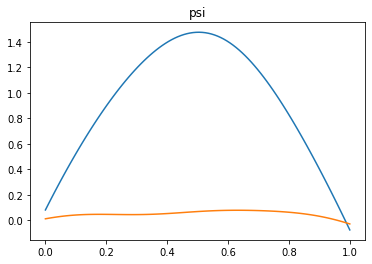

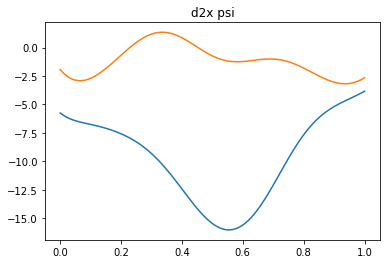

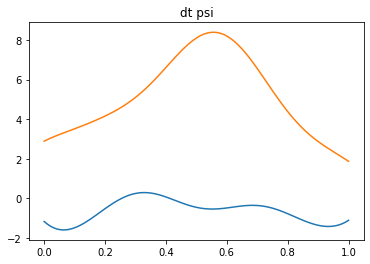

In [46]:
import matplotlib.pyplot as plt

def schrodinger_loss(output, inputs):
    batch_size = output.shape[0]
    
    psi_real = output[:,0]
    psi_imag = output[:,1]

    plt.figure()
    plt.plot(np.linspace(0,1,100), psi_real.cpu().detach().numpy())
    plt.plot(np.linspace(0,1,100), psi_imag.cpu().detach().numpy())
    plt.title('psi')    
    
    # Calculate Laplacian
    # dx = 1e-4 # TODO Make sure the precsion of this is no less than the precision of input
    # inputs_x_minus = inputs.clone()
    # inputs_x_minus[:,0] -= dx
    # inputs_x_plus = inputs.clone()
    # inputs_x_plus[:,0] += dx
    
    # psi_x_minus = model(inputs_x_minus)
    # psi_x_plus = model(inputs_x_plus)
    # psi_d2x = (psi_x_plus + psi_x_minus - 2*output)/(dx**2)

    e_x = torch.zeros((batch_size,302)).to(device)
    e_x[:,0] = 1
    psi_dx = lambda i: torch.autograd.functional.jvp(model, i, v=e_x, create_graph=True)[1]
    psi_d2x = torch.autograd.functional.jvp(psi_dx, inputs, v=e_x, create_graph=True)[1]
    
    psi_d2x_real = psi_d2x[:,0]
    psi_d2x_imag = psi_d2x[:,1]

    plt.figure()
    plt.plot(np.linspace(0,1,100), psi_d2x_real.cpu().detach().numpy())
    plt.plot(np.linspace(0,1,100), psi_d2x_imag.cpu().detach().numpy())
    plt.title('d2x psi')
    
    # Calculate time derivative
    # dt = 1e-5
    # inputs_t_minus = inputs.clone()
    # inputs_t_minus[:,1] -= dt
    # inputs_t_plus = inputs.clone()
    # inputs_t_plus[:,1] += dt
    
    # psi_t_minus = model(inputs_t_minus)
    # psi_t_plus = model(inputs_t_plus)
    
    # psi_dt = (psi_t_plus - psi_t_minus)/(2*dt)
    
    e_t = torch.zeros((batch_size,302)).to(device)
    e_t[:,1] = 1
    psi_dt = torch.autograd.functional.jvp(model, inputs, v=e_t, create_graph=True)[1]
    
    psi_dt_real = psi_dt[:,0]
    psi_dt_imag = psi_dt[:,1]

    plt.figure()
    plt.plot(np.linspace(0,1,100), psi_dt_real.cpu().detach().numpy())
    plt.plot(np.linspace(0,1,100), psi_dt_imag.cpu().detach().numpy())
    plt.title('dt psi')
    
    # Calculate potential energy
    # V_grid = inputs[:,2*grid_size+2:]
    # V = batch_interp(V_grid,inputs[:,0])
    V = 0
    
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # Calculate loss
    diff_1 = psi_dt_real - 0.5*psi_d2x_imag + V_imag
    diff_2 = psi_dt_imag + 0.5*psi_d2x_real - V_real

    return torch.mean(diff_1**2 + diff_2**2)

xs = torch.linspace(0, 1, 100).float()
ts = torch.tensor([0]).float()
    
xts = torch.cartesian_prod(xs,ts)

print(xts.shape)

nn_in = torch.zeros((len(xts), 3*grid_size + 2))
nn_in[:,0:2] = xts
nn_in[:,2:102] = np.sqrt(2)*torch.sin(np.pi*xs)
nn_in = nn_in.to(device)

sl = schrodinger_loss(model(nn_in), nn_in)

print(f'schrod loss is {sl}')